In [58]:
import cv2
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import re
import pandas as pd 

In [59]:
TRAINING_DIR = './archive/dataset/train'
TESTING_DIR = './archive/dataset/test'
piece_symbols = 'prbnkqPRBNKQ'

In [60]:
import os

def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])


n_train = count_files(TRAINING_DIR)
n_test = count_files(TESTING_DIR)

print(f"Number of files in 'Train directory': {n_train}")
print(f"Number of files in 'Testing directory': {n_test}")


Number of files in 'Train directory': 80000
Number of files in 'Testing directory': 20000


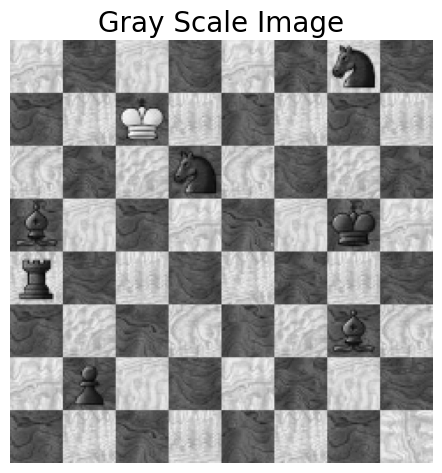

(240, 240)


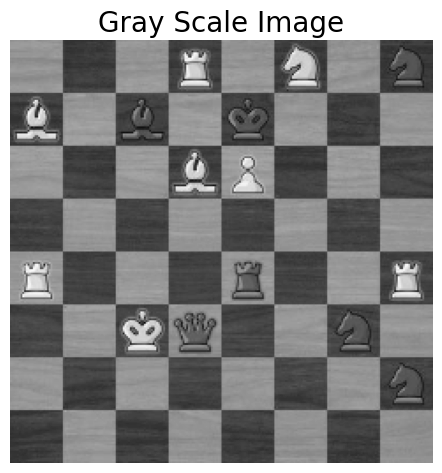

(240, 240)


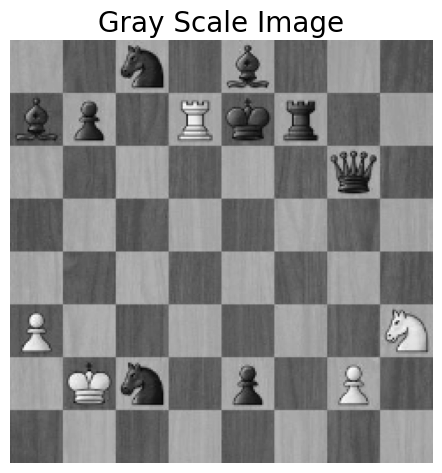

(240, 240)


In [61]:
import os
import random

def random_image(directory):
    """ Returns random image """
    images = [file for file in os.listdir(directory)]
    return random.choice(images)

def preprocess_images(filename, w=400, h=400):
    """ Grayscales, resizes the image and normalizes it """
    image = cv2.imread(filename)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (w, h))

    # Normalize the grayscale image
    normalized_image = gray_image / 255.0

    return normalized_image
       

def plot_random_image(image):
    """ Plots random image"""
    plt.figure(figsize=(12,6))
    plt.subplot(122), plt.imshow(image), plt.axis('off'), plt.title('Gray Scale Image', size=20)
    plt.imshow(image, cmap='gray')
    plt.show()

for i in range(3):
    img = TRAINING_DIR + "/" + random_image(TRAINING_DIR)
    img_gr_scaled = preprocess_images(img, 240, 240)
    plot_random_image(img_gr_scaled)
    print(img_gr_scaled.shape)

In [62]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [63]:
def get_fen_strings(directory):
    filenames = [os.path.splitext(file)[0] for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]
    return filenames
def get_full_file_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]

In [64]:
FEN_TRAINING = get_fen_strings(TRAINING_DIR)
FEN_VALIDATION = get_fen_strings(TESTING_DIR)
TRAINING_LABELS = np.array([onehot_from_fen(fen) for fen in FEN_TRAINING])
VALIDATION_LABELS = np.array([onehot_from_fen(fen) for fen in FEN_VALIDATION])


In [65]:
from skimage import io, transform, color
from skimage.util import view_as_blocks

def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size / 8)
    
    # Read the image
    img_read = io.imread(img)

    # Check if the image is grayscale (2D array), if so convert it to RGB (3D array)
    if len(img_read.shape) == 2:
        img_read = color.gray2rgb(img_read)
    elif img_read.shape[2] == 4:  # Check for RGBA format and convert to RGB
        img_read = color.rgba2rgb(img_read)

    # Resize the image
    img_read = transform.resize(img_read, (downsample_size, downsample_size), anti_aliasing=True)

    # Check if the image has the right number of channels (3 for RGB)
    if img_read.shape[2] != 3:
        raise ValueError("Image does not have 3 channels (RGB)")

    # Split the image into 64 tiles (8x8 grid)
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    return tiles.reshape(64, square_size, square_size, 3)


In [66]:
def train_gen(features, labels, batch_size):
    num_samples = len(features)
    while True:  # Loop indefinitely
        for offset in range(0, num_samples, batch_size):
            batch_features = features[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]

            x_train = np.array([process_image(img) for img in batch_features])
            y_train = np.array([onehot_from_fen(label) for label in batch_labels])

            # Flatten the batches
            x_train = x_train.reshape(-1, 25, 25, 3)  # Reshape to (batch_size * 64, 25, 25, 3)
            y_train = y_train.reshape(-1, 13)  # Reshape to (batch_size * 64, 13)

            yield x_train, y_train
            
def validation_gen(features, labels, batch_size):
    num_samples = len(features)
    while True:  # Loop indefinitely
        for offset in range(0, num_samples, batch_size):
            batch_features = features[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]

            # Process images and labels
            x_val = np.array([process_image(img) for img in batch_features])
            y_val = np.array([onehot_from_fen(label) for label in batch_labels])

            # Flatten the batches
            x_val = x_val.reshape(-1, 25, 25, 3)  # Reshape to (batch_size * 64, 25, 25, 3)
            y_val = y_val.reshape(-1, 13)  # Reshape to (batch_size * 64, 13)

            yield x_val, y_val


def pred_gen(features, batch_size):
    num_samples = len(features)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_features = features[offset:offset + batch_size]

            x_pred = np.array([process_image(img) for img in batch_features])

            yield x_pred


In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5), # Regularization using dropout
        Dense(num_classes, activation='softmax')  # softmax for multi-class classification
    ])

    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


input_shape = (25, 25, 3)  
num_classes = 13  # One for each chess piece type plus one for empty square
model = build_model(input_shape, num_classes)
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 23, 23, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 11, 11, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 9, 9, 32)          4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [75]:
import glob
train = glob.glob("./archive/dataset/train/*.jpeg")
test = glob.glob("./archive/dataset/test/*.jpeg")


In [ ]:
train_size = len(train)  # Number of training samples
batch_size = 64  # Batch size
validation_size = len(test)  # Number of validation samples

# Train the model
history = model.fit(
    x=train_gen(train, FEN_TRAINING, batch_size),
    steps_per_epoch=train_size // batch_size,
    epochs=3, 
    validation_data=validation_gen(test, FEN_VALIDATION, batch_size),
    validation_steps=validation_size // batch_size
)

Epoch 1/3
   1/1250 [..............................] - ETA: 8:25 - loss: 2.6378 - accuracy: 0.0403

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4096x1x64xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4096x1x64xi1>'


1250/1250 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9549

In [52]:
model.save('chess_fen_model1.h5')

In [53]:
# Load and preprocess the image
preprocessed_image = process_image('/Users/ablayaman/Desktop/chessboard-position-detection/test positions/Screenshot 2024-01-08 at 17.31.36.png')

In [54]:
# Reshape the image for prediction: (64, 25, 25, 3) -> (64, 25, 25, 3)
# Since the model expects a batch, we keep the batch dimension as is
predictions = model.predict(preprocessed_image)


2/2 [==============================] - 0s 23ms/step


In [55]:
def predictions_to_fen(predictions):
    fen_string = ""
    for row in predictions.reshape(8, 8, -1):
        empty_count = 0
        for square in row:
            piece_index = np.argmax(square)
            if piece_index == 12:  # Empty square
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_string += str(empty_count)
                    empty_count = 0
                fen_string += piece_symbols[piece_index]
        if empty_count > 0:
            fen_string += str(empty_count)
        fen_string += '/'
    return fen_string.rstrip('/')  # Replace slashes with dashes if needed

# Get the FEN string
fen = predictions_to_fen(predictions)


In [56]:
fen

'BnbkN1Nb/NPkNN2b/N6p/5N1b/N4N2/N3N2b/NNPB2K1/KKNNBRNb'